Processing property: Band gap


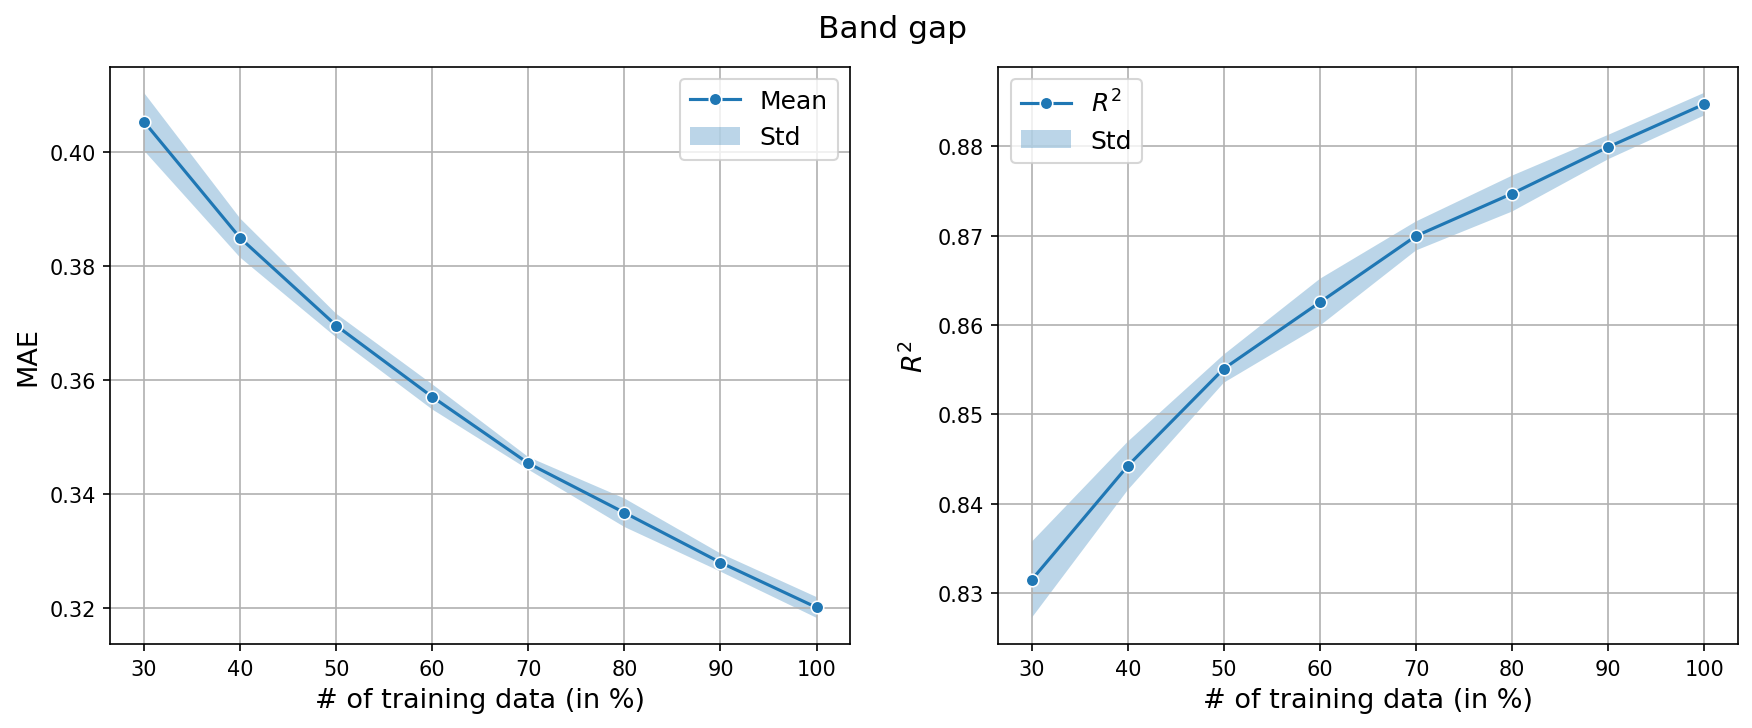

Processing property: Density


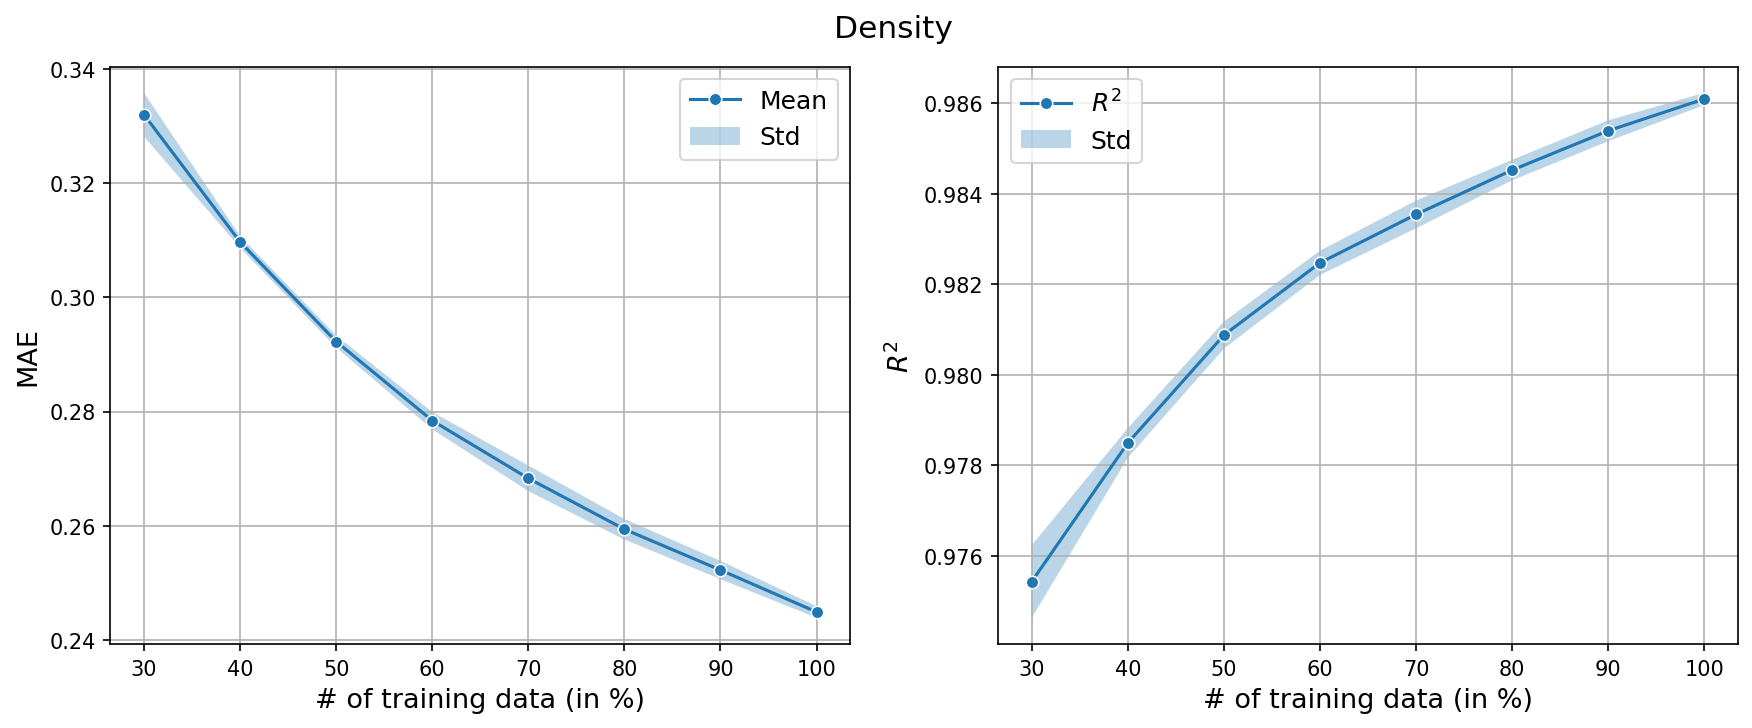

Processing property: Efermi


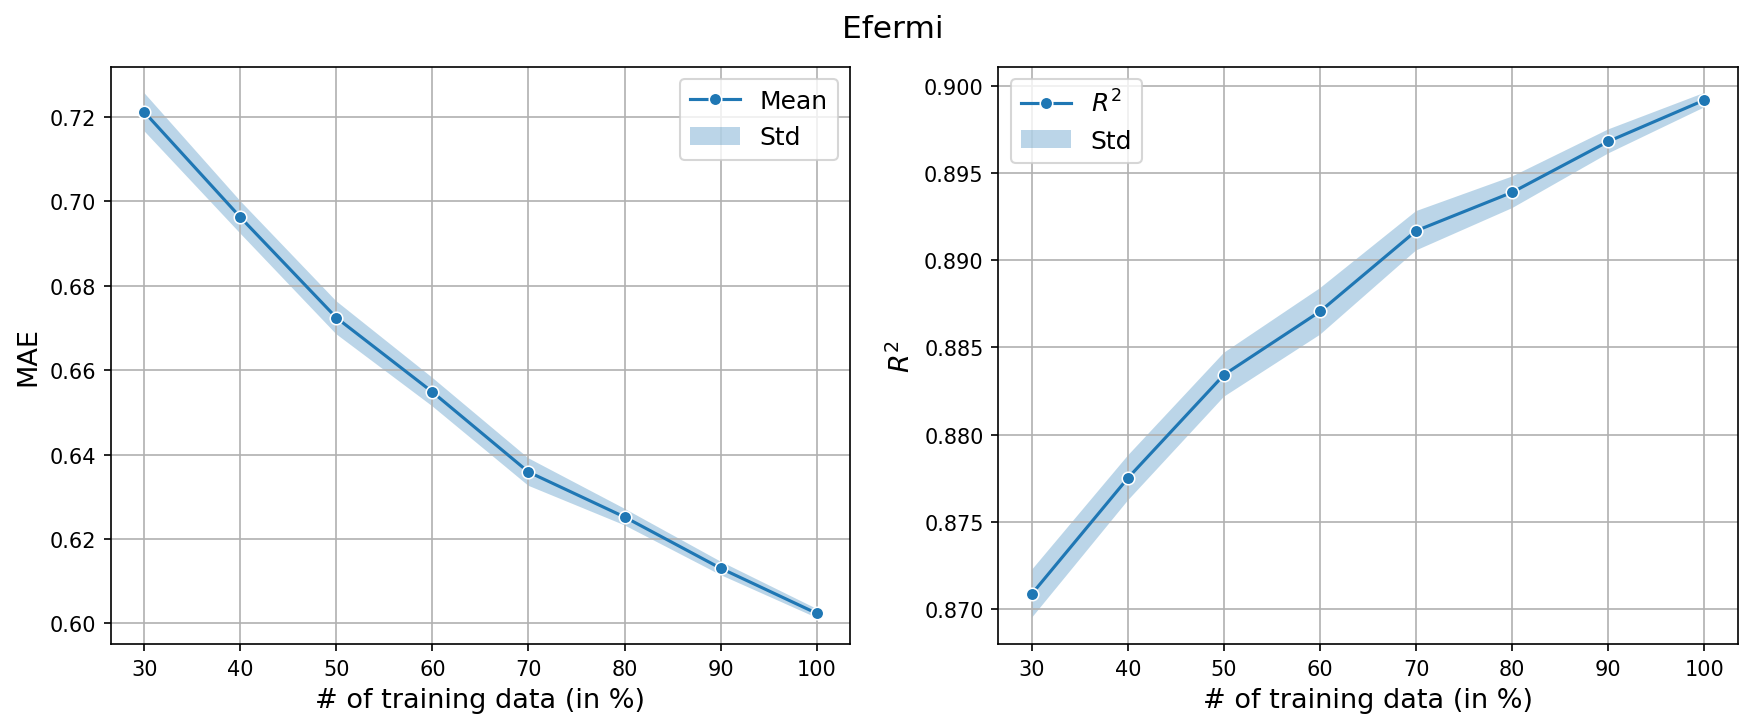

Processing property: Final energy per atom


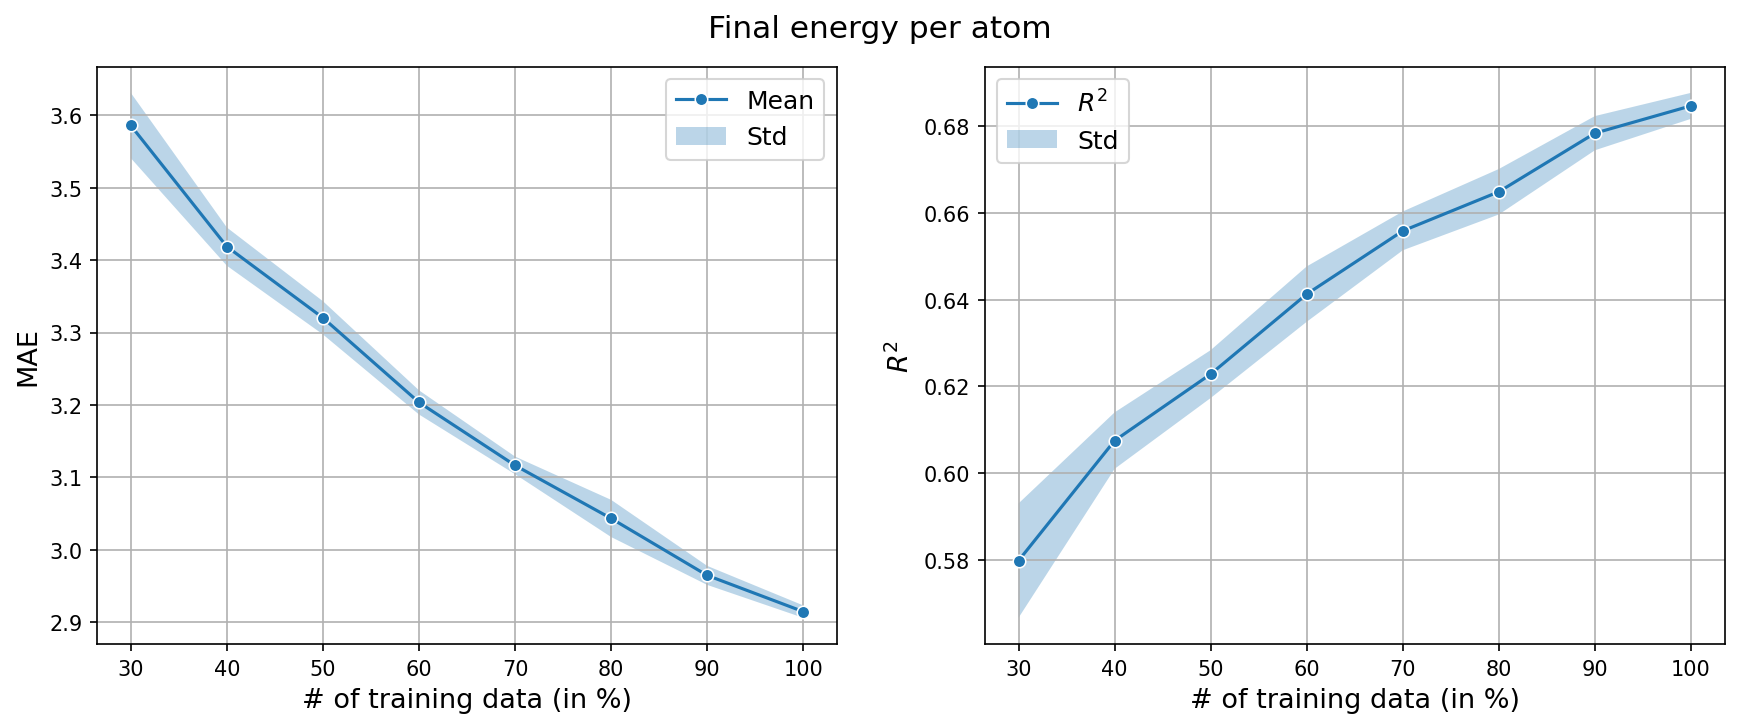

Processing property: Formation energy per atom


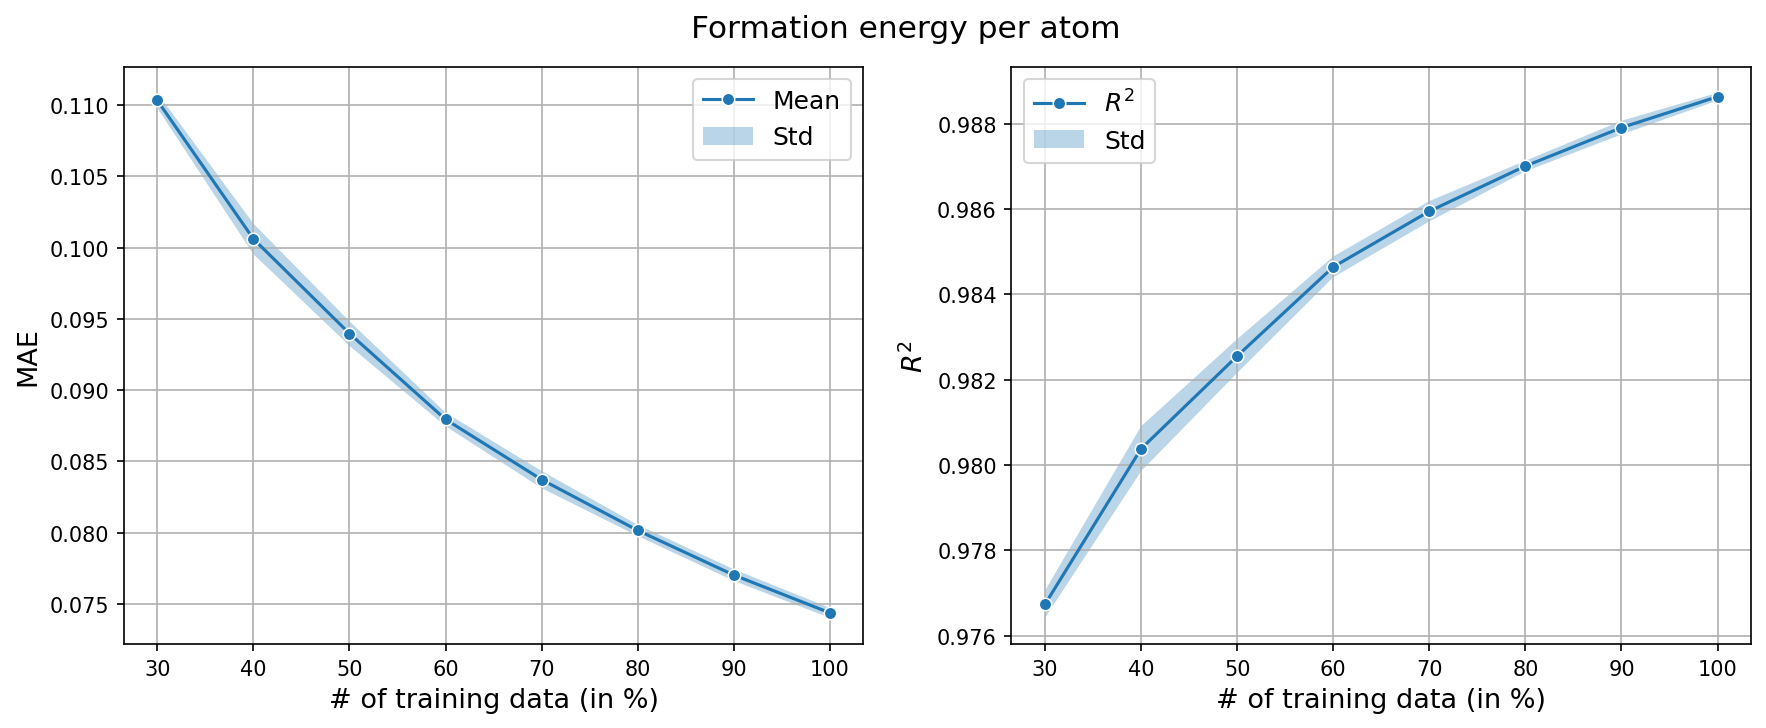

Processing property: Total magnetization


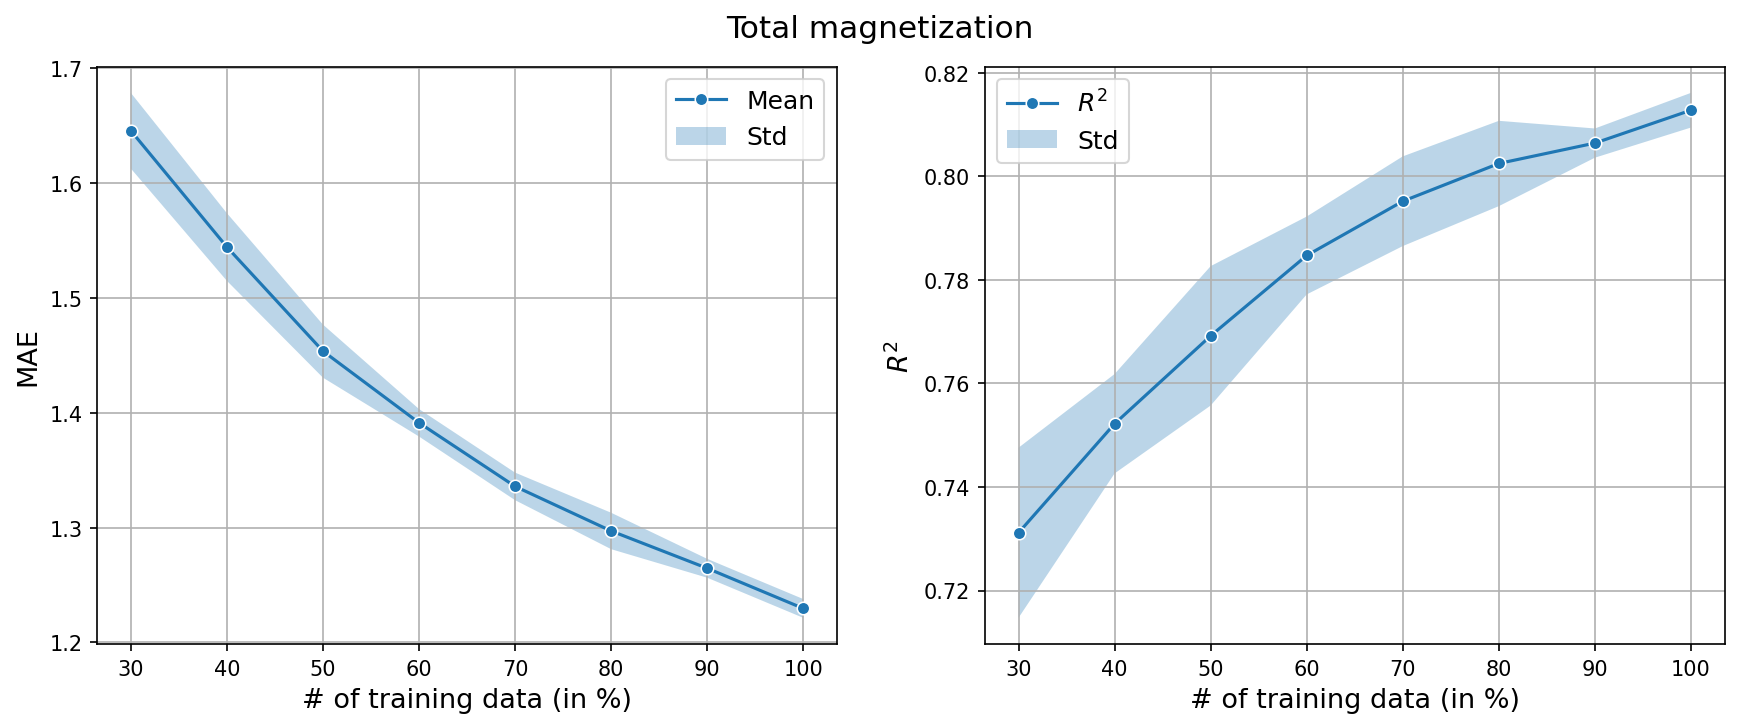

Processing property: Volume


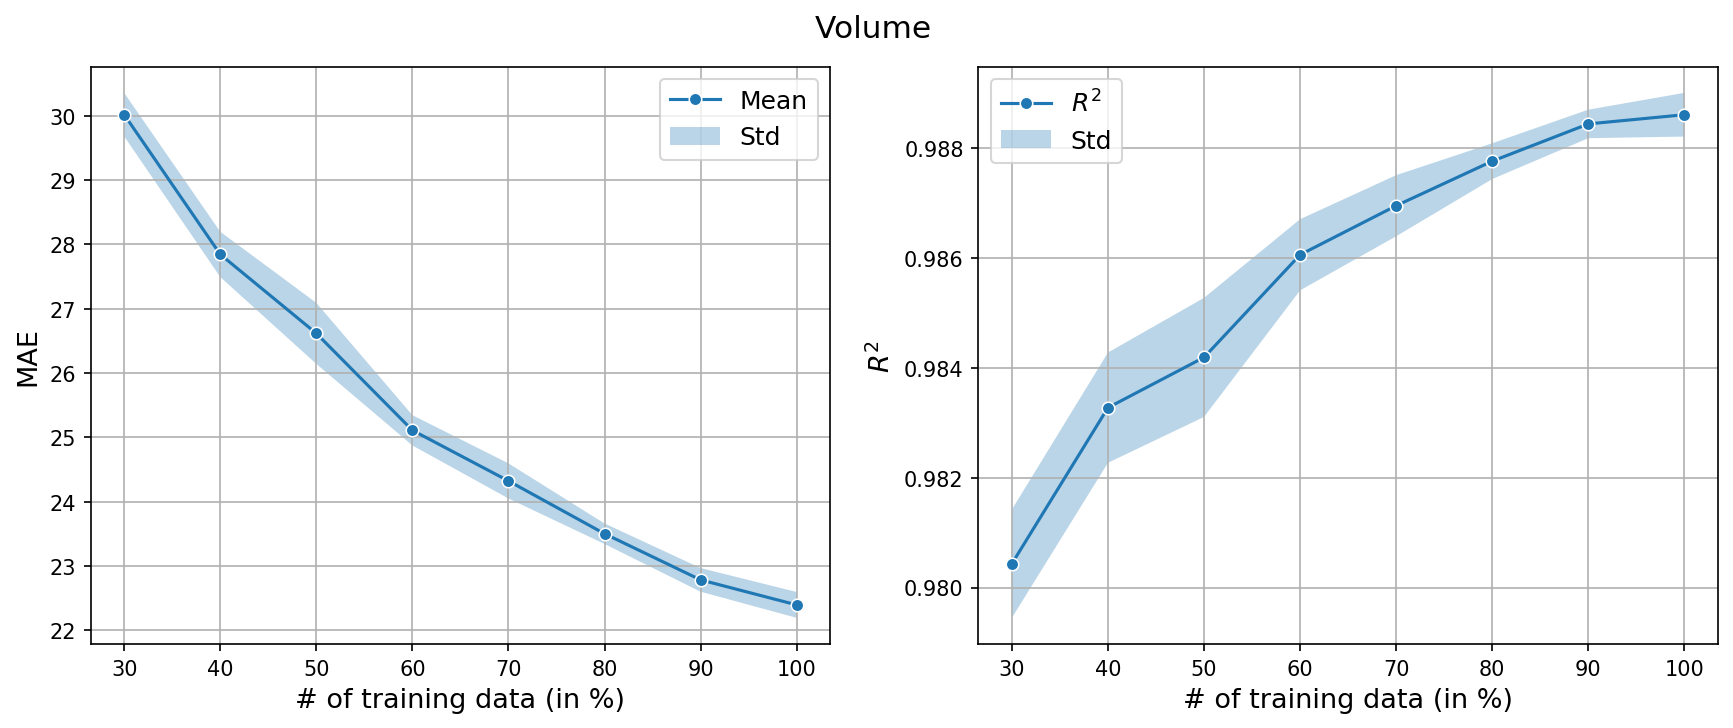

Processing property: Dielectric total


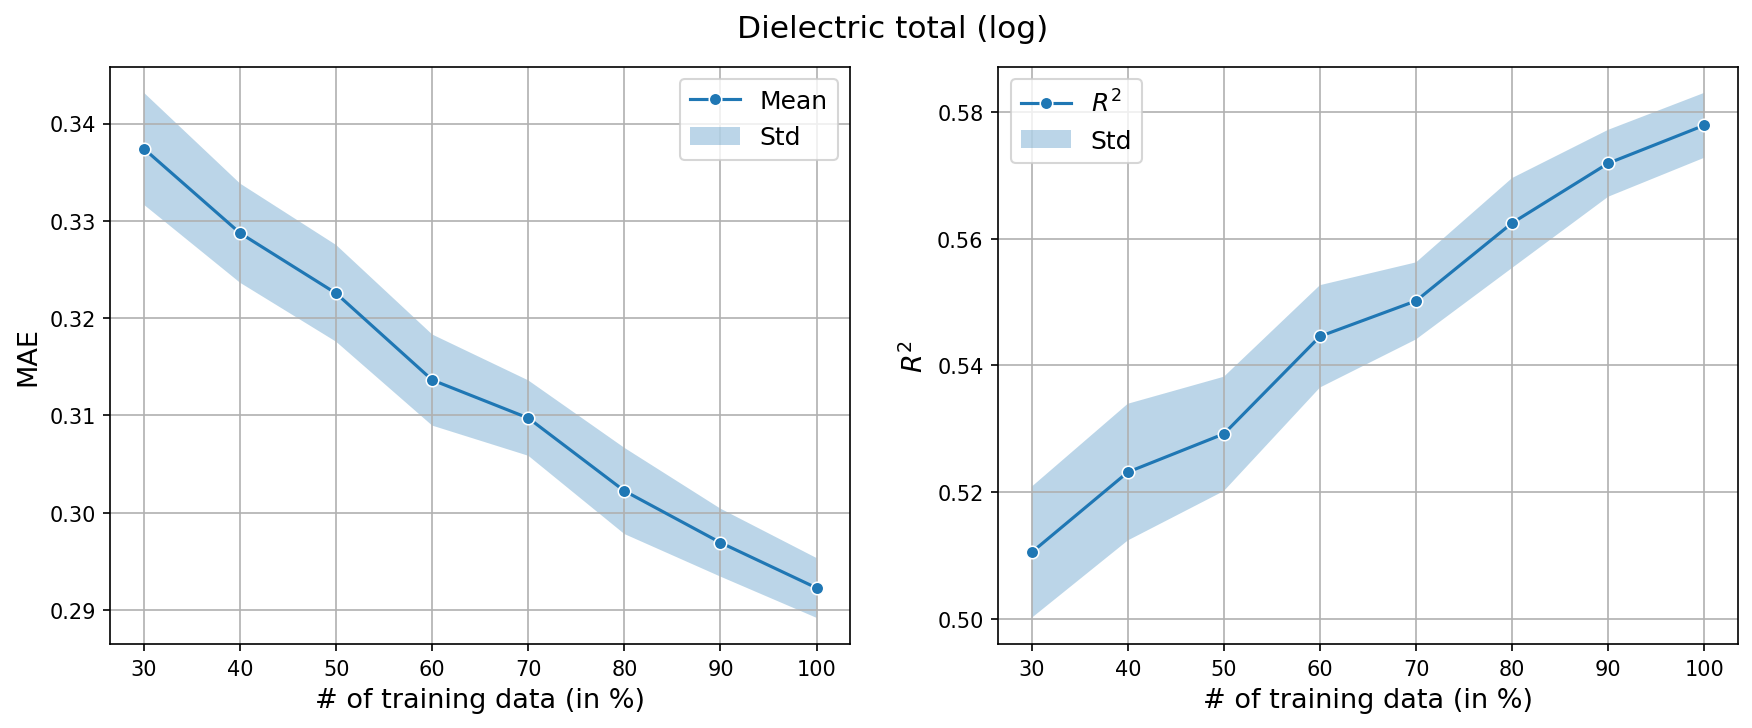

Processing property: Dielectric ionic


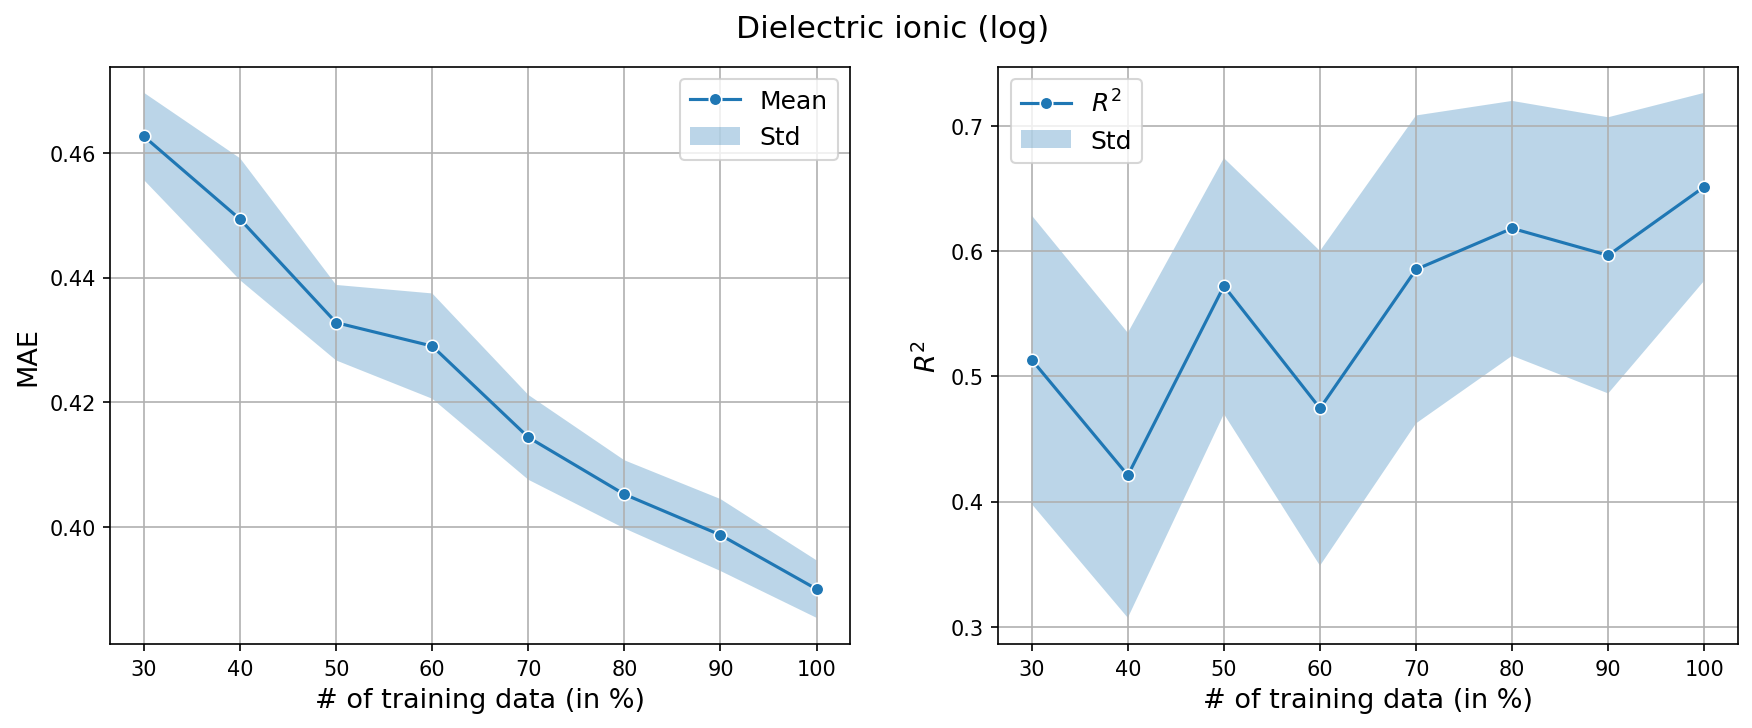

Processing property: Dielectric electronic


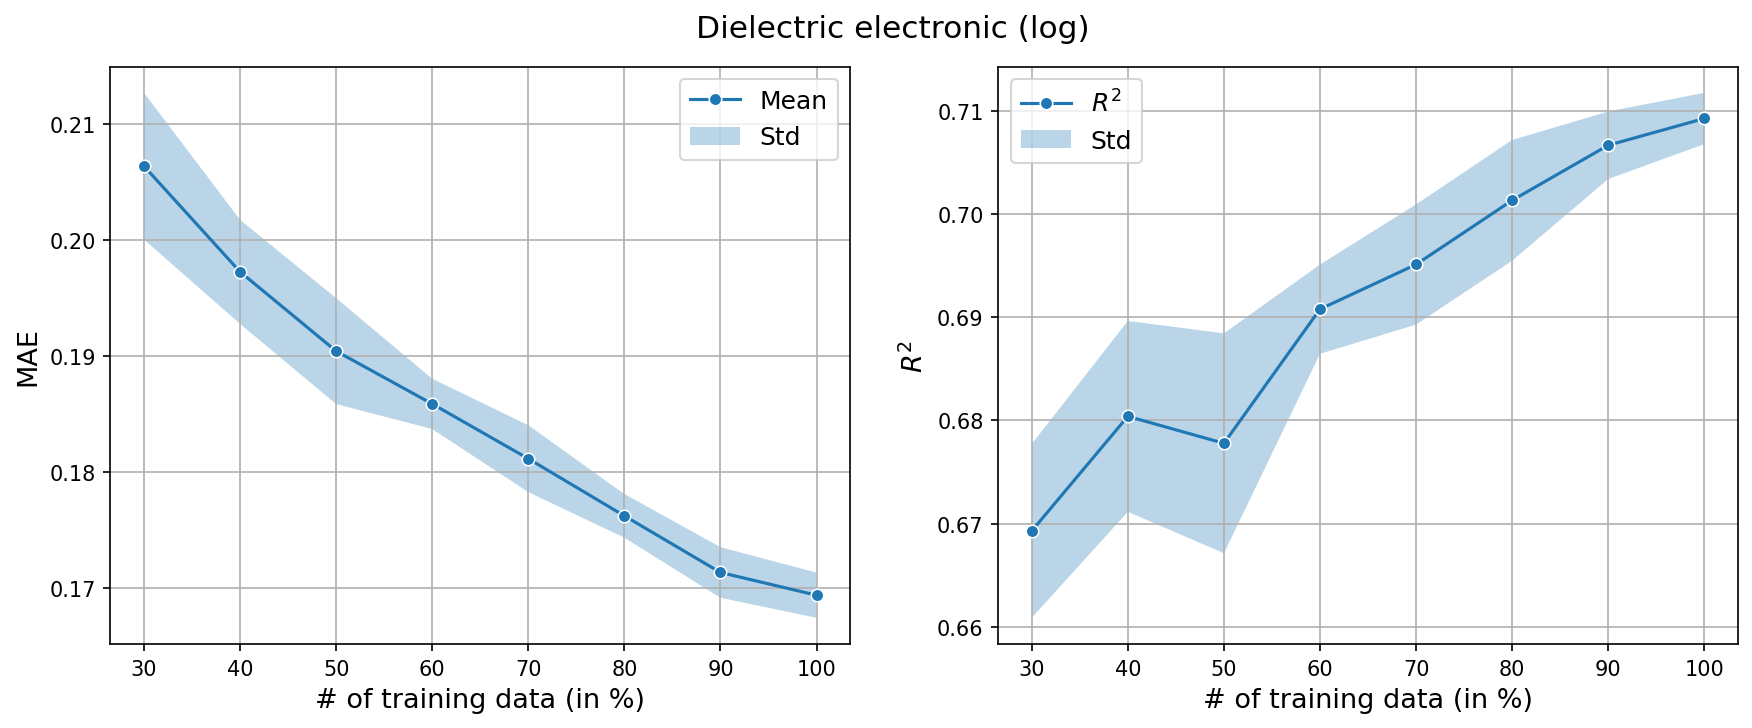

In [2]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

props = [
    "Band gap",  # 0
    "Density",  # 1
    "Efermi",  # 2
    "Final energy per atom",  # 3
    "Formation energy per atom",  # 4
    "Total magnetization",  # 5
    "Volume",  # 6
    "Dielectric total",  # 7
    "Dielectric ionic",  # 8
    "Dielectric electronic",  # 9
]

for prop_name in props:
    print(f"Processing property: {prop_name}")

    # 定义 prediction 文件夹路径
    prediction_dir = Path(f"/data/foundation_model/notebooks/logs/regression/{prop_name}")

    # # 用于存储所有 trial 的 metrics
    metrics_list = []

    for result_dir in prediction_dir.iterdir():
        if result_dir.is_dir() and result_dir.name not in [".ipynb_checkpoints", "summary"]:
            ratio = result_dir.name.split("_")[-1]
            ratio = float(ratio[1:])
            for pred_dir in (result_dir / "predictions").iterdir():
                if pred_dir.is_dir() and pred_dir.name.startswith("trial_"):
                    n_trial = int(pred_dir.name.split("_")[-1])
                    metrics_path = pred_dir / "metrics.json"
                    if metrics_path.exists():
                        with open(metrics_path, "r") as f:
                            metrics = json.load(f)
                            # print(f"Metrics for {result_dir.name}: {metrics}")
                        metrics.update({"ratio": ratio, "trial": n_trial})
                        metrics_list.append(metrics)

    # # 整理成 DataFrame
    df_metrics = pd.DataFrame(metrics_list).sort_values(by=["ratio", "trial"])
    df_metrics = df_metrics[df_metrics["ratio"] >= 0.3]

    grouped = df_metrics.groupby("ratio")[["mae", "r2"]]
    mean_mae = grouped.mean()
    std_mae = grouped.std()

    percent_index = mean_mae.index * 100
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=150)
    plt.subplots_adjust(wspace=0.2)
    sns.lineplot(x=percent_index, y=mean_mae["mae"].values, marker="o", ax=ax1, label="Mean")
    ax1.fill_between(
        percent_index,
        mean_mae["mae"].values - std_mae["mae"].values,
        mean_mae["mae"].values + std_mae["mae"].values,
        alpha=0.3,
        label="Std",
    )
    ax1.set_xlabel("# of training data (in %)", fontsize=13)
    ax1.set_ylabel("MAE", fontsize=13)
    # ax1.set_title(f"{prop_name}", fontsize=13)
    ax1.legend(fontsize=12)
    ax1.grid(True)

    sns.lineplot(x=percent_index, y=mean_mae["r2"].values, marker="o", ax=ax2, label=r"$R^2$")
    ax2.fill_between(
        percent_index,
        mean_mae["r2"].values - std_mae["r2"].values,
        mean_mae["r2"].values + std_mae["r2"].values,
        alpha=0.3,
        label="Std",
    )
    ax2.set_xlabel("# of training data (in %)", fontsize=13)
    ax2.set_ylabel(r"$R^2$", fontsize=13)
    # ax2.set_title(f"{prop_name} (normalized)", fontsize=13)
    ax2.legend(fontsize=12)
    ax2.grid(True)
    fig.suptitle(
        f"{prop_name} {'(log) ' if prop_name in ['Dielectric total', 'Dielectric ionic', 'Dielectric electronic'] else ''}",
        fontsize=15,
        y=0.95,
    )

    # 保存df_metrics为csv和parquet格式
    summary_dir = prediction_dir / "summary"
    summary_dir.mkdir(parents=True, exist_ok=True)
    df_metrics.to_csv(summary_dir / "df_metrics.csv", index=False)
    df_metrics.to_parquet(summary_dir / "df_metrics.parquet", index=False)

    # 保存fig为png格式
    fig.savefig(summary_dir / "metrics_plot.png", bbox_inches="tight", dpi=200)

    plt.show()